In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import joblib

import numpy as np
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [3]:
from utils import clean_text

[nltk_data] Downloading package stopwords to /home/cisco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/cisco/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/cisco/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Loading tweets data set

In [4]:
twitter = pd.read_csv("tweets.csv")
twitter.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


### checking for the shape of the data 

In [5]:
twitter.shape

(27481, 4)

In [6]:
twitter.columns

Index(['textID', 'text', 'selected_text', 'sentiment'], dtype='object')

### checking for missing value

In [7]:
twitter.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [8]:
tweet = twitter.dropna()

### checking if there are still missing values

In [9]:
tweet.isnull().sum()

textID           0
text             0
selected_text    0
sentiment        0
dtype: int64

### performing feature engineering removing unnecessary columns

In [10]:
tweet.drop(columns=['textID'], axis =1)

,text,selected_text,sentiment
0,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,my boss is bullying me...,bullying me,negative
3,what interview! leave me alone,leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...
27476,wish we could come see u on Denver husband l...,d lost,negative
27477,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,But it was worth it ****.,But it was worth it ****.,positive


### Getting the length of each sentence

In [11]:
tweet['length'] = tweet['text'].apply(lambda X: len(str(X).split(' ')))

### creating an output for the sentiment into two whcih is positive, negative

In [12]:
tweet['sentiment_review'] = tweet['sentiment'].map({'positive':'positive', 'neutral':'positive', 'negative':'negative'})
tweet.drop(columns = ['sentiment', 'textID'])

,text,selected_text,length,sentiment_review
0,"I`d have responded, if I were going","I`d have responded, if I were going",8,positive
1,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,11,negative
2,my boss is bullying me...,bullying me,5,negative
3,what interview! leave me alone,leave me alone,6,negative
4,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",15,negative
...,...,...,...,...
27476,wish we could come see u on Denver husband l...,d lost,18,negative
27477,I`ve wondered about rake to. The client has ...,", don`t force",26,negative
27478,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,24,positive
27479,But it was worth it ****.,But it was worth it ****.,8,positive


### graphic representation of the sentence 

<BarContainer object of 39 artists>

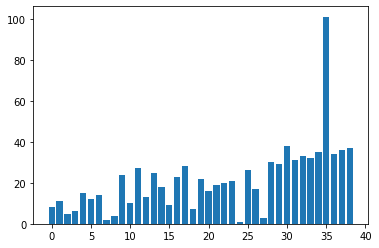

In [13]:
unique_lengths = tweet['length'].unique()
plt.bar(np.arange(len(unique_lengths)), unique_lengths)

### ### checking the value of sentiments

In [14]:
print(tweet['sentiment_review'].value_counts())

positive    19699
negative     7781
Name: sentiment_review, dtype: int64


### checking for unique words among the snetence

In [15]:
tweet['selected_text'].unique()

array(['I`d have responded, if I were going', 'Sooo SAD', 'bullying me',
       ..., 'Yay good for both of you.', 'But it was worth it  ****.',
       'All this flirting going on - The ATG smiles. Yay.  ((hugs)'],
      dtype=object)

### getting the array of the word

In [16]:
tweet['length'].unique()

array([  8,  11,   5,   6,  15,  12,  14,   2,   4,  24,  10,  27,  13,
        25,  18,   9,  23,  28,   7,  22,  16,  19,  20,  21,   1,  26,
        17,   3,  30,  29,  38,  31,  33,  32,  35, 101,  34,  36,  37])

### Plot of the sentiment

positive    19699
negative     7781
Name: sentiment_review, dtype: int64



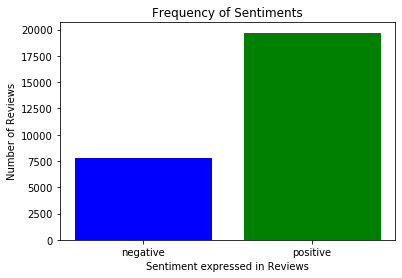

In [17]:
Index = [1, 0]

print(tweet["sentiment_review"].value_counts())
print()

barlist = plt.bar(Index, tweet["sentiment_review"].value_counts())

plt.title("Frequency of Sentiments")
plt.xticks(Index, ['positive', 'negative'])
plt.ylabel('Number of Reviews')
plt.xlabel('Sentiment expressed in Reviews')

barlist[Index[1]].set_color('green')
barlist[Index[0]].set_color('blue')
# barlist[Index[0]].set_color('red')
plt.show()

### Application of clean text for bags of word 

In [18]:
tweet['selected_text'] = tweet['selected_text'].apply(clean_text)

### Visualizing the most frequent words used in the review

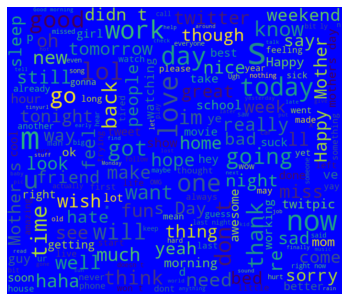

In [19]:
word = " ".join([text for text in tweet['text']])

rainy_word = WordCloud(width = 700, height = 600, random_state = 90, max_font_size = 80, background_color = "blue").generate(word)

plt.figure(figsize = (6, 12))
plt.imshow(rainy_word, interpolation = "bilinear")
plt.axis('off')
plt.show()

### splitting the data set into x and y train and test

In [29]:
x = tweet['selected_text']
y = tweet['sentiment_review']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 30, random_state = 90)

In [31]:
X_train.shape

(27450,)

In [32]:
y_train.shape

(27450,)

### Creating a pipeline for training dataset using frequency based 

In [33]:
multi_NB = Pipeline([
    ("bag of words", CountVectorizer(stop_words="english")),
    ("classification", MultinomialNB())
])

In [34]:
multi_NB.fit(X_train, y_train)

Pipeline(steps=[('bag of words', CountVectorizer(stop_words='english')),
                ('classification', MultinomialNB())])

### creating a joblib file

In [35]:
joblib.dump(multi_NB, "models/multinomial_naive_bayes_with_count_vectorizer.joblib")

['models/multinomial_naive_bayes_with_count_vectorizer.joblib']

### validating the train data with test data set

In [36]:
X_predict = multi_NB.predict(X_test)

print(classification_report(y_test, X_predict))

              precision    recall  f1-score   support

    negative       1.00      0.43      0.60         7
    positive       0.85      1.00      0.92        23

    accuracy                           0.87        30
   macro avg       0.93      0.71      0.76        30
weighted avg       0.89      0.87      0.85        30



### getting the confussion metrics 

In [37]:
confusion_matrix(y_test, X_predict)

array([[ 3,  4],
       [ 0, 23]])

### Creating a pipeline for training dataset using frequency based 

In [38]:
multi_NBT = Pipeline([
    ("bag of words", TfidfVectorizer(stop_words="english")),
    ("classification", MultinomialNB())
])

In [40]:
multi_NBT.fit(X_train, y_train)

Pipeline(steps=[('bag of words', TfidfVectorizer(stop_words='english')),
                ('classification', MultinomialNB())])

In [41]:
joblib.dump(multi_NBT, "models/multinomial_naive_bayes_with_tfidf_vectorizer.joblib")

['models/multinomial_naive_bayes_with_tfidf_vectorizer.joblib']

In [43]:
X_predict = multi_NBT.predict(X_test)

print(classification_report(y_test, X_predict))

              precision    recall  f1-score   support

    negative       1.00      0.43      0.60         7
    positive       0.85      1.00      0.92        23

    accuracy                           0.87        30
   macro avg       0.93      0.71      0.76        30
weighted avg       0.89      0.87      0.85        30

